In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd


data = pd.read_csv('Data/chosen_data.csv')
data.drop('Unnamed: 0', inplace=True, axis=1)

np.random.seed(42)

X,y = data.drop('diagnosed_diabetes', axis=1), data['diagnosed_diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

X_train

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,screen_time_hours_per_day,waist_to_hip_ratio,diastolic_bp,ldl_cholesterol,triglycerides,family_history_diabetes
57105,35,1,134,7.9,7.7,0.82,70,84,97,0
660816,64,4,72,5.2,8.5,0.81,66,118,123,0
295318,50,2,91,6.2,6.7,0.85,77,80,156,0
447035,61,3,116,4.7,5.9,0.94,74,103,151,0
106260,31,3,65,6.7,10.2,0.82,73,129,85,0
...,...,...,...,...,...,...,...,...,...,...
525621,32,4,216,2.3,7.2,0.90,84,103,129,0
359213,54,2,89,6.2,7.0,0.87,71,81,127,0
196287,59,4,100,5.5,4.1,0.81,85,112,114,0
141263,60,1,65,6.2,3.5,0.91,78,120,151,0


## Metrics

In [2]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, classification_report, ConfusionMatrixDisplay, \
    RocCurveDisplay, roc_auc_score


def metrics(preds:np.ndarray, probs:np.ndarray, lables:np.ndarray, method:str):
    cf_mtx = confusion_matrix(lables, preds)
    fpr, tpr, thresholds = roc_curve(lables, probs)
    roc_area = roc_auc_score(lables, probs)
    accuracy = accuracy_score(lables, preds)

    print(classification_report(lables, preds))

    text = f"{roc_area=}\n{accuracy=}"

    cf_mtx_disp = ConfusionMatrixDisplay(confusion_matrix=cf_mtx)
    roc_disp = RocCurveDisplay(fpr=fpr,tpr=tpr)

    fig, (ax_report, ax_matrix, ax_roc) = plt.subplots(1, 3, figsize=(16, 4))
    ax_report.text(
        x=0.05,
        y=0.95,
        s=text,
        family='monospace',
        fontsize=16,
        verticalalignment='top',
        transform=ax_report.transAxes)
    ax_report.set_title(f'Metrics for {method}')
    ax_report.axis('off')

    ax_matrix.set_title("Confusion Matrix")
    ax_matrix.grid(False)
    ax_matrix = cf_mtx_disp.plot(ax=ax_matrix, cmap='grey')

    ax_roc.set_title('ROC Curve')
    ax_roc.plot(fpr,tpr, linewidth=2, label='ROC Curve', color='red')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')


    return {"accuracy": accuracy, "roc_score": roc_area}

# Logistic and Poly features

In [3]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=2)),('clf', LogisticRegression())])


pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('poly', PolynomialFeatures()),
                ('clf', LogisticRegression())])

              precision    recall  f1-score   support

         0.0       0.59      0.35      0.44    131854
         1.0       0.68      0.85      0.76    218146

    accuracy                           0.66    350000
   macro avg       0.64      0.60      0.60    350000
weighted avg       0.65      0.66      0.64    350000



{'accuracy': 0.66258, 'roc_score': 0.6937546041104515}

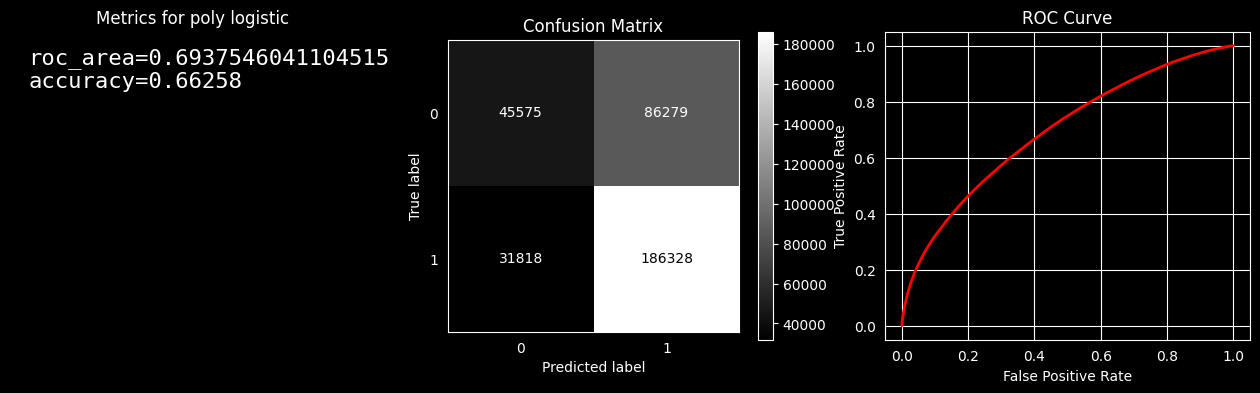

In [4]:
metrics(pipe.predict(X_test), pipe.predict_proba(X_test)[:,1], y_test, "poly logistic")

# Optuna for poly logistic
On all data set

In [ ]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def objective(trial):
    global  X, y
    # 1. Suggest hyperparameters
    # Degree of polynomial features
    poly_degree = trial.suggest_int('poly__degree', 1, 4)

    # Logistic Regression hyperparameters
    c_reg = trial.suggest_float('clf__C', 1e-5, 100, log=True)
    solver = trial.suggest_categorical('clf__solver', ['lbfgs', 'liblinear'])
    tol = trial.suggest_float('clf__tol', 1e-5, 1e-1, log=True)
    max_iter = trial.suggest_int('clf__max_iter', 100, 2000)

    # 2. Define the pipeline with suggested params
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
        ('clf', LogisticRegression(C=c_reg, solver=solver, max_iter=max_iter, tol=tol, class_weight='balanced')),
    ])

    # 3. Perform Cross-Validation
    # We use 'roc_auc' as the scoring metric
    score = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc', n_jobs=-1)

    # Return the mean ROC AUC across folds
    return score.mean()

# --- Execution ---
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-12-29 20:19:58,191] A new study created in memory with name: no-name-d1867854-a47f-49f3-9cde-14b669efe8fd


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-29 20:21:32,476] Trial 0 finished with value: 0.6941433975803079 and parameters: {'poly__degree': 3, 'clf__C': 0.0007078027387968645, 'clf__solver': 'liblinear', 'clf__tol': 0.007658227880264688, 'clf__max_iter': 542}. Best is trial 0 with value: 0.6941433975803079.


# Results and saving optimized pipline

In [ ]:
study.best_params

In [ ]:
import pickle

pipe.set_params(**study.best_params)

pipe.fit(X,y)

## Saving

In [ ]:
name = 'Logistic_Poly_full'
with open(f'models/{name}.pkl', 'wb') as f:
    pickle.dump(pipe, f)


## Test Predict

In [ ]:
import os
import numpy as np

data_kaggle = pd.read_csv('Data/chosen_test.csv')
data_kaggle.drop('Unnamed: 0', axis=1, inplace=True)

submission_name = "RF_pruned.csv"
ids = np.arange(700000, 1000000)

probs = pipe.predict_proba(data_kaggle)[:, 1]
submission = pd.DataFrame({
    "id": ids,
    "diagnosed_diabetes": probs
})

PATH = os.path.join('results',submission_name)

submission.to_csv(PATH, index=False, float_format="%.6f")
submission.head()